In [1]:
import datetime
import requests
import pandas
import unlzw3
import os
from pathlib import Path
from io import StringIO 
from datetime import date
from astropy.io import fits
from urllib.request import urlretrieve
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
today_dt = date.today()
if datetime.datetime.now().hour < 10: today_dt = today_dt - datetime.timedelta(days=1)
yesterday_dt = today_dt - datetime.timedelta(days=1)
today = today_dt.strftime(format="%Y %m %d").replace(" ","%20")
yesterday = yesterday_dt.strftime(format="%Y %m %d").replace(" ","%20")
# more dates can be added or subtracted - note the "exists" flag
files_dict = {'now': {'date':today, 'filename': 'FEROS_TODAY',"exists":False}, 'yesterday': {'date':yesterday, 'filename': 'FEROS_YESTERDAY',"exists":True}, 'ref1': {'date':"2021%2009%2006",'filename':'FEROS_REFERENCE_1','exists':True}, 'ref2': {'date':"2018%2005%2010",'filename':'FEROS_REFERENCE_2','exists':True}}
line_slices = [
  [2796,2808,412,448],
  [1580,1595,1430,1470],
  [2153,2164,966,1000]
]
line_data = []
colours = "kbgrcmy"
vmin=240;vmax=370
keys = list(files_dict.keys())

Analysing FEROS_TODAY
FEROS_TODAY doesn't exist, downloading and creating
Analysing FEROS_YESTERDAY
Analysing FEROS_REFERENCE_1
Analysing FEROS_REFERENCE_2


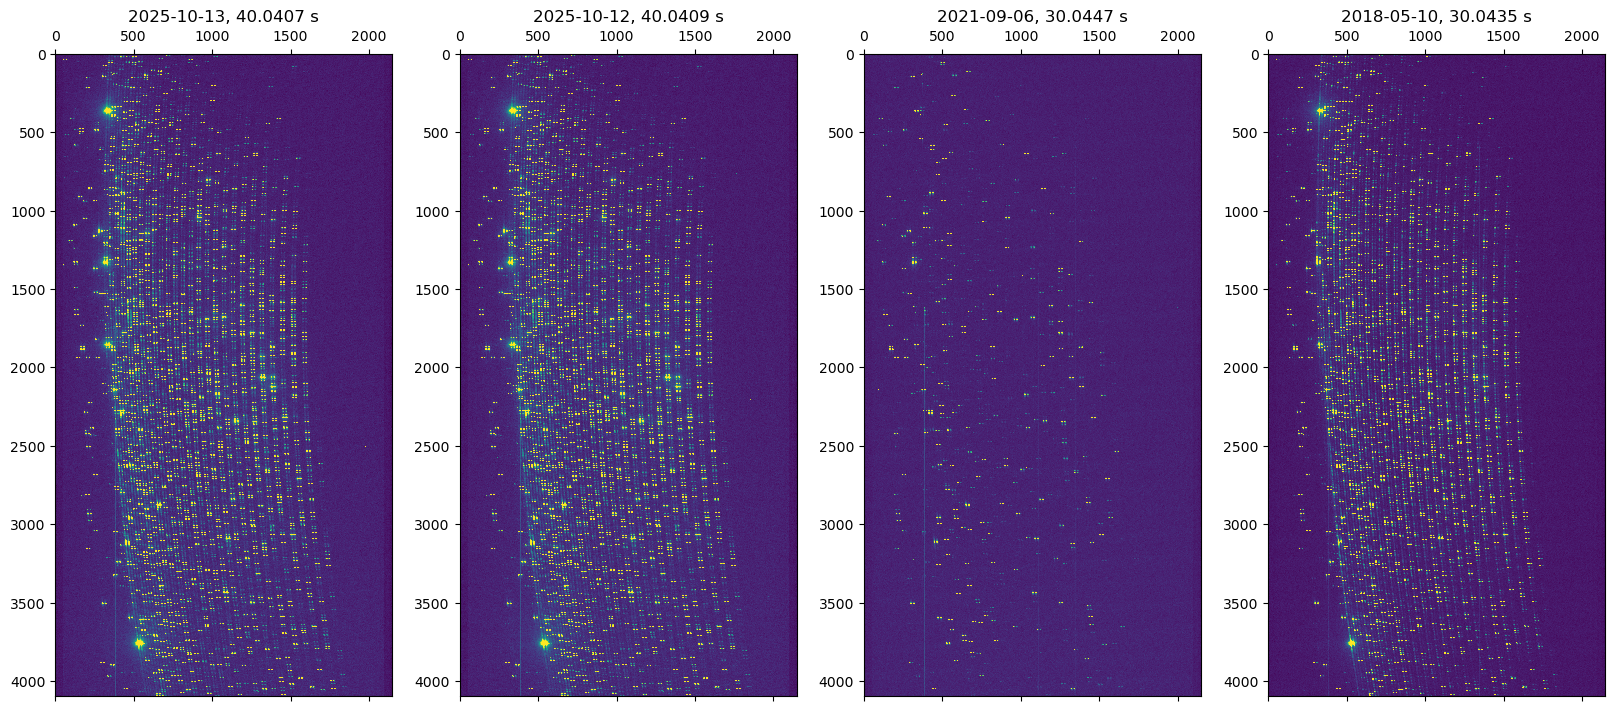

In [5]:
fig,ax=plt.subplots(nrows=1,ncols=len(keys),figsize=(20, 20))
for a,k in zip(ax,keys):
  filename = files_dict[k]["filename"]
  filename_zip = filename+".Z"
  filename_fits = filename+".fits"
  print(f"Analysing {filename}")
 # step one: query ESO on each date
  if not files_dict[k].get("exists"):
    print(f"{filename} doesn't exist, downloading and creating")
    url = f"""https://archive.eso.org/wdb/wdb/eso/eso_archive_main/query?wdbo=csv&max_rows_returned=200&instrument=FEROS
&tab_object=on&target=&resolver=simbad&ra=&dec=&box=00%2010%2000&degrees_or_hours=hours&tab_target_coord=on
&format=SexaHour&wdb_input_file=&tab_night=on&night={files_dict[k]['date']}&stime=&starttime=12&etime=&endtime=12
&tab_prog_id=on&prog_id=&gto=&pi_coi=&obs_mode=&title=&image[]=GROND&image[]=WFI&spectrum[]=FEROS
&tab_dp_cat=on&dp_cat=CALIB&tab_dp_type=on&dp_type=WAVE&dp_type_user=&tab_dp_tech=on&dp_tech=
&dp_tech_user=&tab_dp_id=on&dp_id=&origfile=&tab_rel_date=on&rel_date=&obs_name=&ob_id=&tab_tpl_start=on
&tpl_start=&tab_tpl_id=on&tpl_id=&tab_exptime=on&exptime=&tab_filter_path=on&filter_path=&tab_wavelength_input=on
&wavelength_input=&tab_fwhm_input=on&fwhm_input=&gris_path=&grat_path=&slit_path=&tab_instrument=on
&tab_tel_airm_start=on&tab_stat_instrument=on&tab_ambient=on&tab_stat_exptime=on&tab_HDR=on&tab_mjd_obs=on
&aladin_colour=aladin_instrument&order=tpl_start&"""
    _response = requests.get(url)
    response = _response.text
    observed_data = pandas.read_table(StringIO(response),sep=",")
 # step two: get last file with  30s < exptime < 60s
    observed_data = observed_data[observed_data["Exptime"]>=30]
    observed_data = observed_data[observed_data["Exptime"]<=60]
    url = 'https://dataportal.eso.org/dataPortal/file/' + observed_data.iloc[-1]["Dataset ID"]
 # step three: download, unzip and create file
    urlretrieve(url, filename=filename_zip)
    extracted_data = unlzw3.unlzw(Path(filename_zip))
    if os.path.exists(filename_fits): os.remove(filename_fits)
    file_now = open(filename_fits,"wb")
    file_now.write(extracted_data)
    file_now.close()
 # step four: extract and plot data 
  hdu = fits.open(filename_fits,ignore_missing_simple=True)
  header = hdu[0].header
  data = hdu[0].data
  a.matshow(data,vmin=vmin,vmax=vmax)
  lines_data = []
  for l in line_slices:
    lines_data.append(data[l[0]:l[1],l[2]:l[3]])
  line_data.append(lines_data)
  a.set_title(f"{(header['DATE']).split('T')[0]}, {header['EXPTIME']} s")
plt.savefig("wavelenght_comparison_fullspec.png",dpi=300)

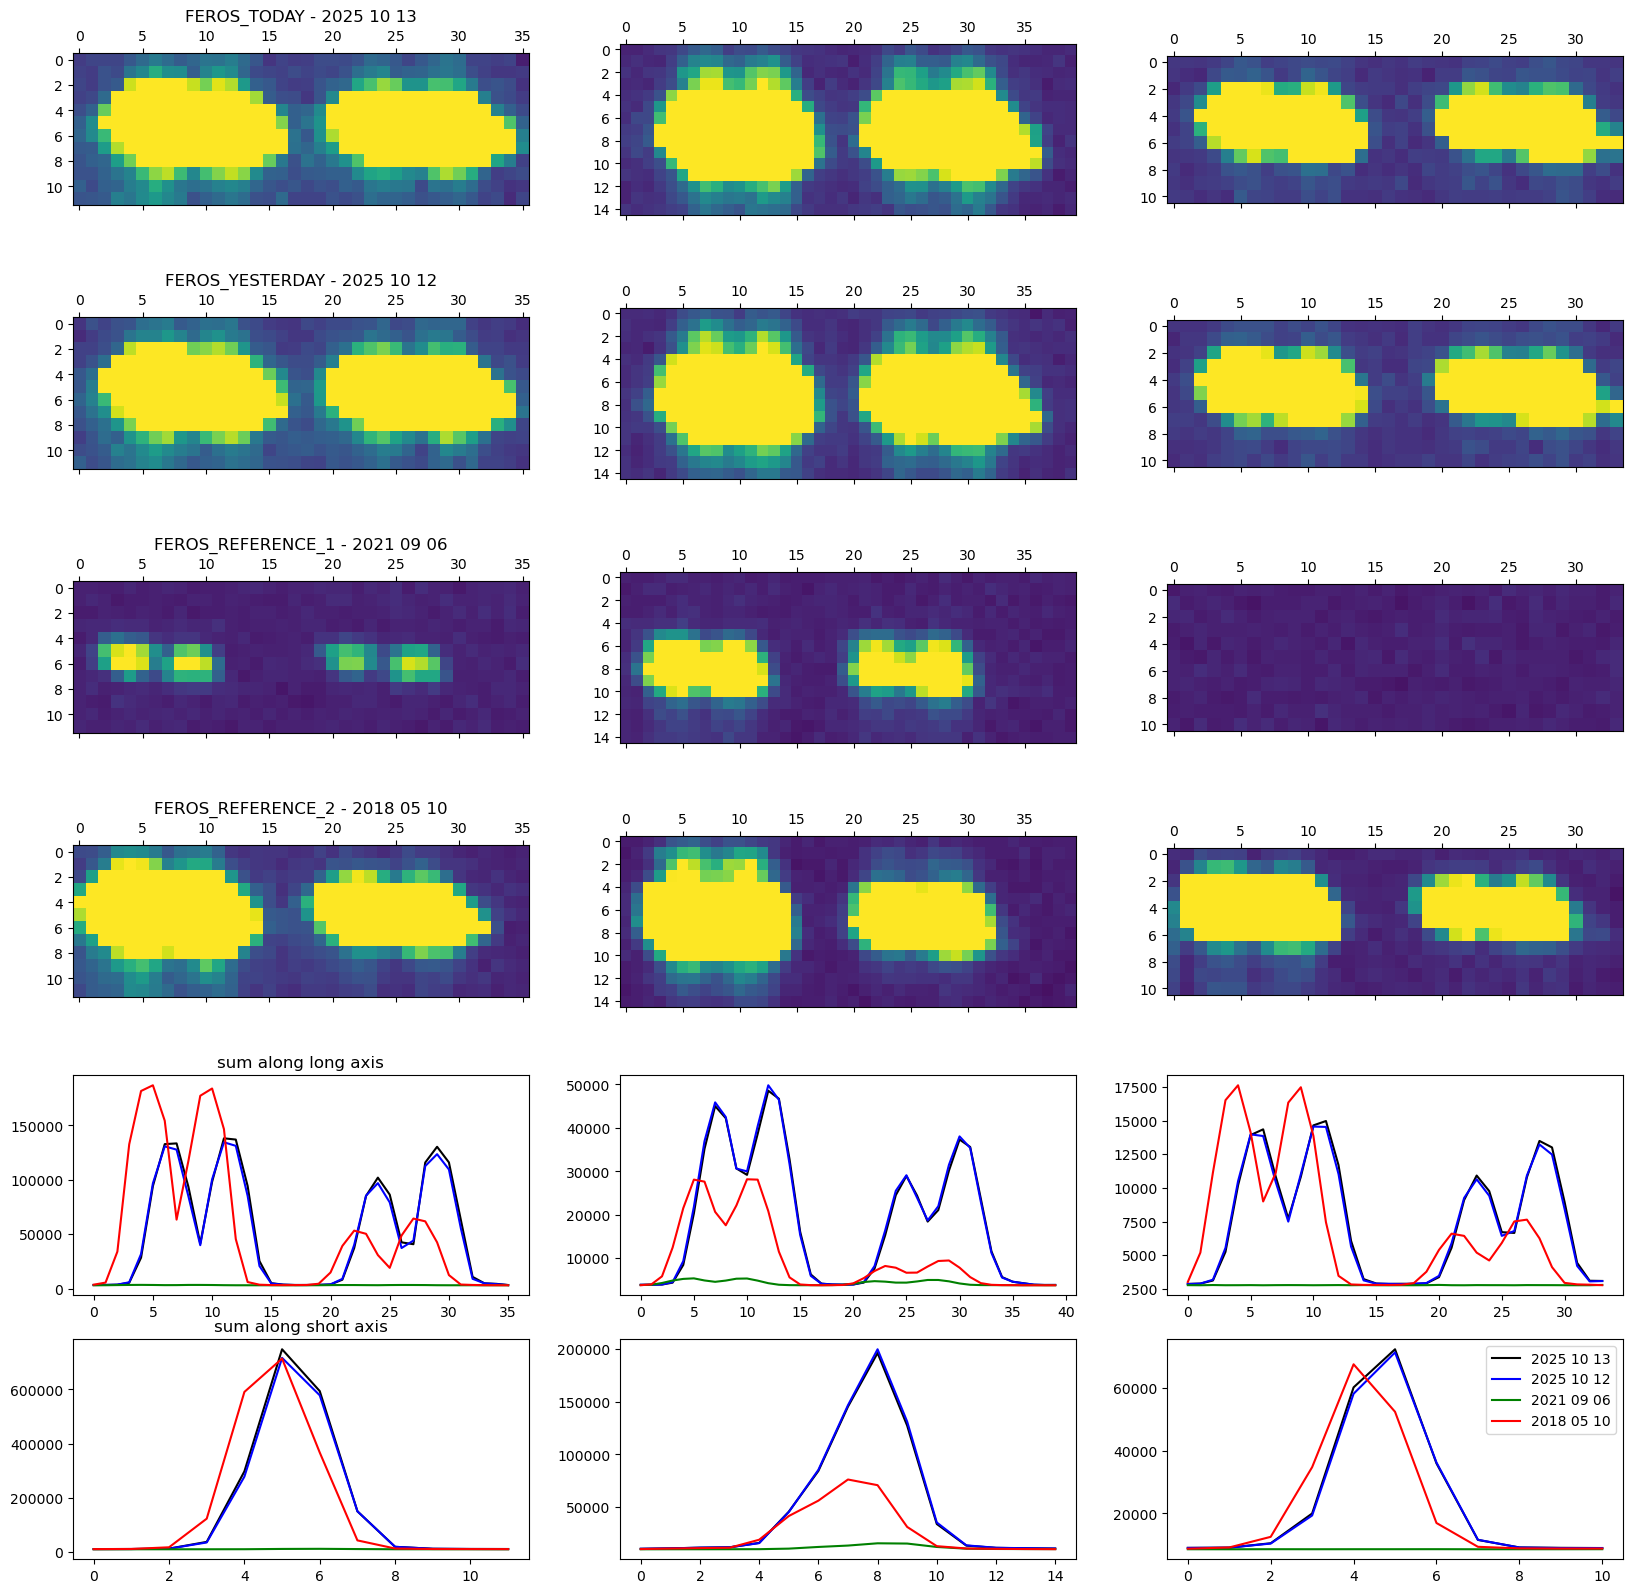

In [6]:
fig,ax = plt.subplots(ncols = len(line_slices),nrows = len(line_data)+2,figsize=(20,20))
for i,f in enumerate(line_data):
  for j,l in enumerate(f):
    ax[i,j].matshow(l,vmin=vmin,vmax=vmax)
    ax[len(line_data),j].plot(np.sum(l,axis=0),c=colours[i])
    ax[len(line_data)+1,j].plot(np.sum(l,axis=1),c=colours[i],label = (files_dict[keys[i]]["date"]).replace("%20"," "))
  ax[i,0].set_title(files_dict[keys[i]]["filename"]+" - "+(files_dict[keys[i]]["date"]).replace("%20"," "))
  ax[len(line_data),0].set_title("sum along long axis")
  ax[len(line_data)+1,0].set_title("sum along short axis")
ax[len(line_data)+1][-1].legend()
plt.savefig("wavelenght_comparison.png",dpi=300)